# Drug toxicity screening on human iPSC-derived cardiomyocites

## Background

iPSCs are valuable resource to model drug interactions with different tissue and are frequenly used in drug screens to gain insights into drug specificity and toxicity. Tyrosine kinase inhibitors (TKIs) are frequently used drugs in cancer treatment. Unfortunately, cardiomyopathy may occur as a severe side effect of these drugs due to cardiotoxicity.   
  
Here, you will compare the transcriptomes of iPSC-derived cardiomyocites treated with two different FDA-approved TKIs to investigate their toxicity and gain insights into the biological pathways potentially leading to cardiotoxicity.
- Carfilzomib
- Gefinitib

## Objectives
1. Explore the impact on global gene expression patterns (PCA).
2. Identify differentially expressed genes (DEGs) between mutant and WT for both drugs.
3. Visualized DEGs with volcano plots and heatmaps.
4. Perform GO enrichment to determine affected biological pathways.
5. Interpret the cardiotoxic potential of these drugs, and what cellular mechansims they might disrupt.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import scanpy as sc
import anndata as ad
import os
import pandas as pd
import gseapy
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [2]:
counts = pd.read_csv(
    "Session_3_4/split_datasets/counts_msn05_group_4.txt", sep="\t", index_col=0
)
counts

,CAR_1,CAR_2,CAR_3,CAR_4,CTRL_1,CTRL_2,CTRL_3,CTRL_4,CTRL_5,CTRL_6,CTRL_7,CTRL_8,CTRL_9,CTRL_10,CTRL_11,CTRL_12,GEF_1,GEF_2,GEF_3,GEF_4
DDX11L1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WASH7P,51,79,71,57,147,63,65,201,43,54,54,43,66,25,123,97,58,85,61,36
MIR6859-1,2,8,6,4,24,9,0,5,11,6,6,4,5,2,13,12,2,10,6,4
MIR1302-2HG,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
MIR1302-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ND6,15382,10634,12797,11978,107036,73372,45472,8313,28995,54639,40297,32030,132198,62151,81016,73551,32612,29949,136864,52715
TRNE,0,0,0,0,1,0,0,0,0,1,0,1,0,0,5,0,0,0,1,1
CYTB,33626,35587,39467,38969,337937,242836,146674,17113,110922,143736,120934,89561,359665,148701,251132,238506,115165,117685,306581,126033
TRNT,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [3]:
metadata_df = pd.read_csv(
    "Session_3_4/split_datasets/metadata_msn05_group_4.txt", sep="\t", index_col=0
)
metadata_df

,treatment,Concentration,cell_line,cell_type,replicate
CAR_1,Carfilzomib,3uM,MSN05,cardiomyocytes,1
CAR_2,Carfilzomib,3uM,MSN05,cardiomyocytes,2
CAR_3,Carfilzomib,3uM,MSN05,cardiomyocytes,3
CAR_4,Carfilzomib,3uM,MSN05,cardiomyocytes,4
CTRL_1,Control,0nM,MSN05,cardiomyocytes,1
CTRL_2,Control,0nM,MSN05,cardiomyocytes,2
CTRL_3,Control,0nM,MSN05,cardiomyocytes,3
CTRL_4,Control,0nM,MSN05,cardiomyocytes,4
CTRL_5,Control,0nM,MSN05,cardiomyocytes,5
CTRL_6,Control,0nM,MSN05,cardiomyocytes,6


# PCA

In [4]:
total_reads = counts.sum(axis=0)
normalized_count_table = (counts / total_reads) * 1000000
log_transformed_counts = np.log2(normalized_count_table + 1)

In [5]:
scaler = StandardScaler()

scaled_table = scaler.fit_transform(log_transformed_counts.T)

In [6]:
pca = PCA()

pca_result_matrix = pca.fit_transform(scaled_table)

In [7]:
np.shape(pca_result_matrix)

(20, 20)

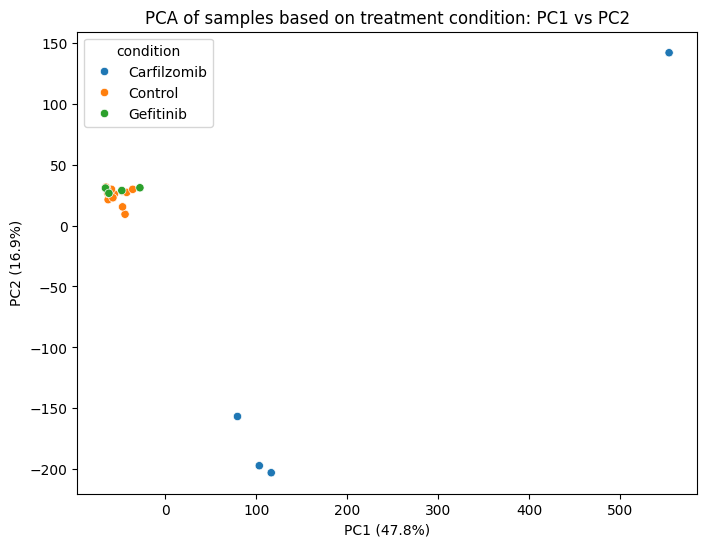

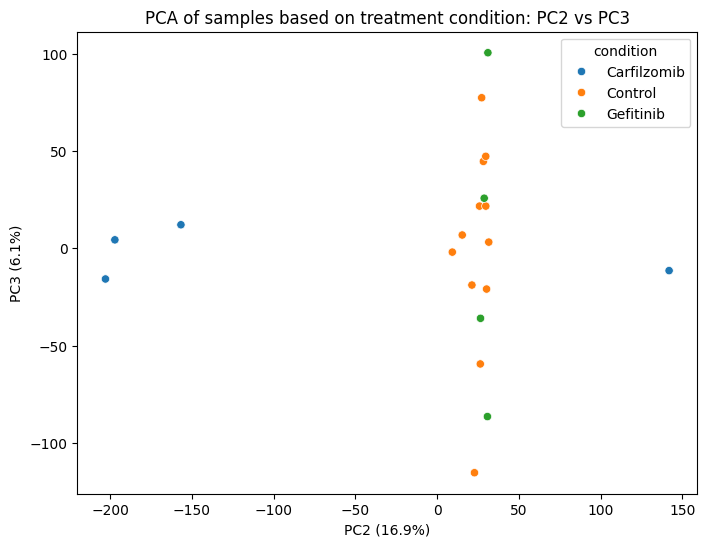

In [8]:
plot_df = pd.DataFrame(
    {
        "PC1": pca_result_matrix[:, 0],
        "PC2": pca_result_matrix[:, 1],
        "PC3": pca_result_matrix[:, 2],
        "condition": metadata_df["treatment"].values,
    }
)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC1", y="PC2", hue="condition")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.title("PCA of samples based on treatment condition: PC1 vs PC2")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="PC2", y="PC3", hue="condition")
plt.xlabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.ylabel(f"PC3 ({pca.explained_variance_ratio_[2] * 100:.1f}%)")
plt.title("PCA of samples based on treatment condition: PC2 vs PC3")
plt.show()

# DEseq2

## Carfilzomib vs Control

In [ ]:
drug = "Carfilzomib"

metadata_df_filtered_car = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_car = counts[metadata_df_filtered_car.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_car.T,
    metadata=metadata_df_filtered_car,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_car = DeseqStats(
    deseq_object, contrast=("treatment", "Carfilzomib", "Control")
)
stat_res_car.summary()
results_df_car = stat_res_car.results_df


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 1.71 seconds.

Fitting dispersion trend curve...
... done in 0.51 seconds.

Fitting MAP dispersions...
... done in 1.73 seconds.

Fitting LFCs...
... done in 1.77 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 1584 outlier genes.

Fitting dispersions...
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 0.17 seconds.

Fitting LFCs...
... done in 0.19 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment Carfilzomib vs Control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DDX11L1           0.000000             NaN       NaN       NaN       NaN   
WASH7P           69.825366        0.443938  0.248505  1.786437  0.074029   
MIR6859-1         6.403075        0.072767  0.615820  0.118162  0.905939   
MIR1302-2HG       0.073659        0.147673  3.827410  0.038583  0.969223   
MIR1302-2         0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ND6           44879.179178       -1.617386  0.407855 -3.965593  0.000073   
TRNE              0.380472       -1.060851  3.228485 -0.328591  0.742465   
CYTB         131170.722704       -1.640906  0.405345 -4.048175  0.000052   
TRNT              0.135701        1.111505  3.695967  0.300735  0.763617   
TRNP            850.019428       -1.320848  0.343486 -3.845417  0.000120   

                

... done in 1.25 seconds.



In [10]:
# Get upregulated and downregulated genes
upregulated_genes_car = results_df_car[
    (results_df_car["log2FoldChange"] > 2) & (results_df_car["padj"] < 0.05)
]
downregulated_genes_car = results_df_car[
    (results_df_car["log2FoldChange"] < -2) & (results_df_car["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_car.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_car.shape[0]}")

    Upregulated genes: 3934
    Downregulated genes: 1603


/home/elianezueger/anaconda3/envs/pydeseq2/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


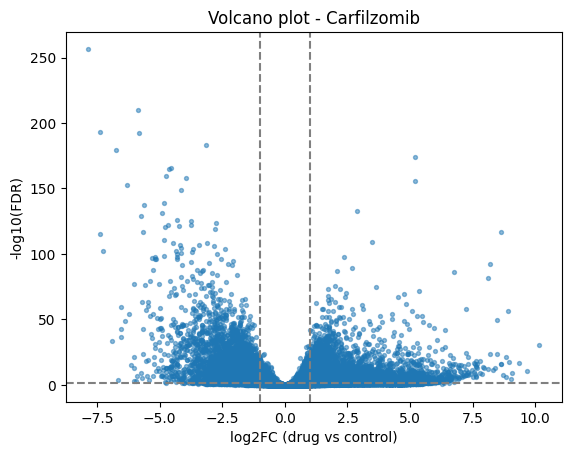

In [11]:
plt.scatter(
    results_df_car.log2FoldChange, -np.log10(results_df_car.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (drug vs control)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()

## Gefinitib vs Control

In [12]:
drug = "Gefitinib"

metadata_df_filtered_gef = metadata_df[metadata_df["treatment"].isin([drug, "Control"])]
counts_filtered_gef = counts[metadata_df_filtered_gef.index]

# Create DESeq2 object
deseq_object = DeseqDataSet(
    counts=counts_filtered_gef.T,
    metadata=metadata_df_filtered_gef,
    design_factors="treatment",
)

# Run DESeq2
deseq_object.deseq2()

# Get results for the current contrast
stat_res_gef = DeseqStats(deseq_object, contrast=("treatment", "Gefitinib", "Control"))
stat_res_gef.summary()
results_df_gef = stat_res_gef.results_df


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 1.35 seconds.

Fitting dispersion trend curve...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 1.47 seconds.

Fitting LFCs...
... done in 1.46 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 184 outlier genes.

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.04 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: treatment Gefitinib vs Control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DDX11L1           0.000000             NaN       NaN       NaN       NaN   
WASH7P           67.989688        0.209950  0.243882  0.860867  0.389311   
MIR6859-1         6.570236        0.087165  0.555794  0.156829  0.875380   
MIR1302-2HG       0.205009        0.774081  3.684159  0.210111  0.833581   
MIR1302-2         0.000000             NaN       NaN       NaN       NaN   
...                    ...             ...       ...       ...       ...   
ND6           61270.934214        0.531070  0.514661  1.031884  0.302126   
TRNE              0.576040        0.264362  1.865682  0.141697  0.887319   
CYTB         173670.016579        0.382910  0.426741  0.897290  0.369564   
TRNT              0.066380        0.295672  3.849808  0.076802  0.938781   
TRNP           1076.775011        0.281788  0.349337  0.806637  0.419876   

                 p

... done in 1.37 seconds.



In [13]:
# Get upregulated and downregulated genes
upregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] > 2) & (results_df_gef["padj"] < 0.05)
]
downregulated_genes_gef = results_df_gef[
    (results_df_gef["log2FoldChange"] < -2) & (results_df_gef["padj"] < 0.05)
]
print(f"    Upregulated genes: {upregulated_genes_gef.shape[0]}")
print(f"    Downregulated genes: {downregulated_genes_gef.shape[0]}")

    Upregulated genes: 0
    Downregulated genes: 11


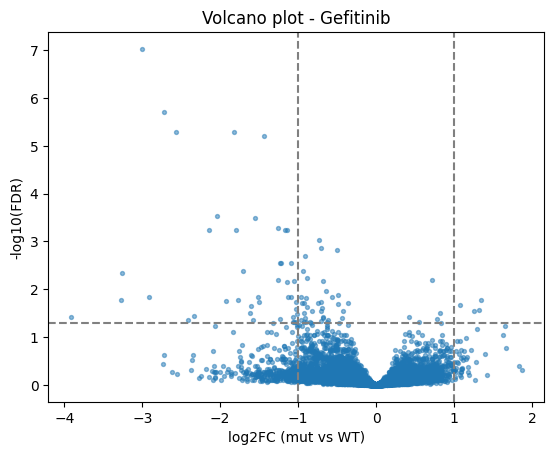

In [14]:
plt.scatter(
    results_df_gef.log2FoldChange, -np.log10(results_df_gef.padj), s=8, alpha=0.5
)
plt.axhline(-np.log10(0.05), ls="--", color="grey")
plt.axvline(1, ls="--", color="grey")
plt.axvline(-1, ls="--", color="grey")
plt.xlabel("log2FC (mut vs WT)")
plt.ylabel("-log10(FDR)")
plt.title(f"Volcano plot - {drug}")
plt.show()

# GSEAPY

In [15]:
GO_databases = [
    "GO_Biological_Process_2025",
    "GO_Cellular_Component_2025",
    "GO_Molecular_Function_2025",
]

## Carfilzomib vs Control

In [16]:
go_upr_results_car = {}
go_dwr_results_car = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_car.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_car[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_car.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_car[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


### Plot upregulated GO terms

In [17]:
for k, v in go_upr_results_car.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

GO_Biological_Process_2025: (3412, 10)
Error occurred while plotting GO_Biological_Process_2025: Warning: No enrich terms when cutoff = 0.05
GO_Cellular_Component_2025: (303, 10)
Error occurred while plotting GO_Cellular_Component_2025: Warning: No enrich terms when cutoff = 0.05
GO_Molecular_Function_2025: (733, 10)
Error occurred while plotting GO_Molecular_Function_2025: Warning: No enrich terms when cutoff = 0.05


In [18]:
display(go_upr_results_car["GO_Biological_Process_2025"].head(5))

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2025,Organic Hydroxy Compound Transport (GO:0015850),21/51,0.000344,0.999996,0,0,2.868694,22.880263,ABCC3;SLC10A4;ABCG8;SLC10A5;SLC10A6;ABCC2;SLC1...
1,GO_Biological_Process_2025,Bile Acid and Bile Salt Transport (GO:0015721),12/25,0.001313,0.999996,0,0,3.778214,25.070645,ABCC3;SLC10A4;SLCO1B1;SLC10A5;SLC10A6;ABCC2;SL...
2,GO_Biological_Process_2025,Male Gamete Generation (GO:0048232),10/24,0.011183,0.999996,0,0,2.921946,13.129281,PRDM9;TDRD9;SPDYA;MEIOB;TAF1L;TEX14;TEX15;TEX1...
3,GO_Biological_Process_2025,Regulation of Lymphocyte Activation (GO:0051249),8/18,0.014710,0.999996,0,0,3.271727,13.804269,THEMIS2;LCK;FCRL3;CD19;LEP;CRTAM;KLRD1;IKZF3
4,GO_Biological_Process_2025,Ag Processing and Presentation of Endogenous P...,6/13,0.027772,0.999996,0,0,3.504292,12.558380,RAET1E;RAET1G;ULBP2;HLA-G;HLA-E;ULBP3


### Plot downregulated GO terms

GO_Biological_Process_2025: (3447, 10)
GO_Cellular_Component_2025: (272, 10)
GO_Molecular_Function_2025: (640, 10)


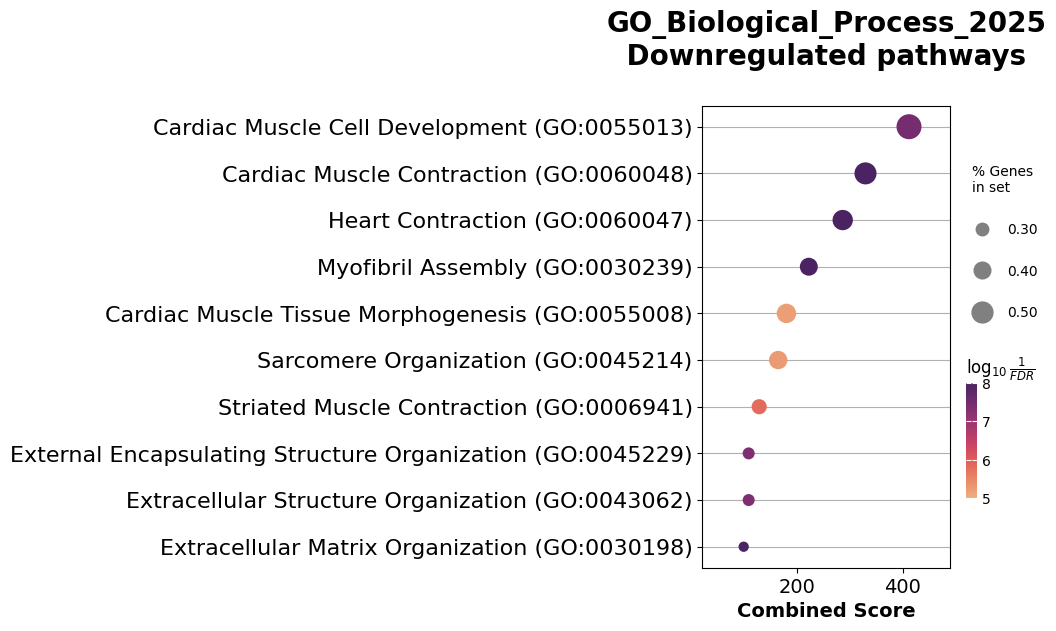

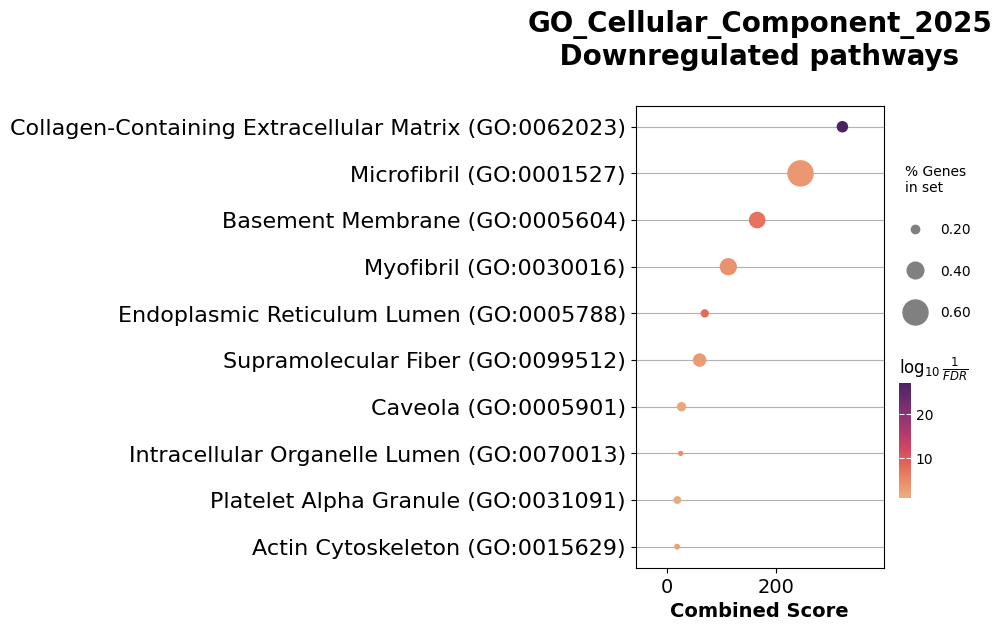

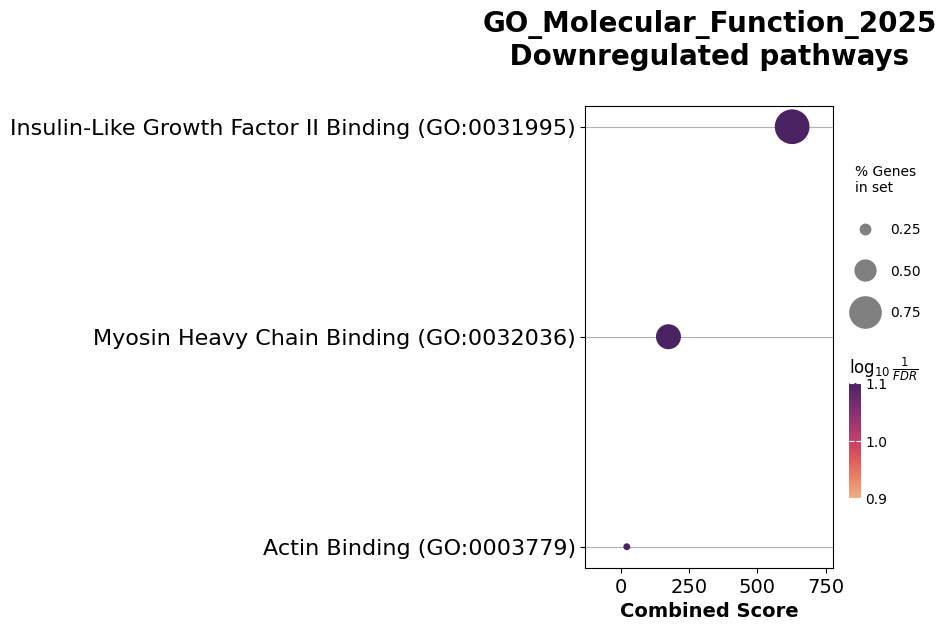

In [19]:
for k, v in go_dwr_results_car.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Downregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

In [20]:
# Check out all results for downregulated GO terms (biological process)
go_dwr_results_car["GO_Biological_Process_2025"][
    go_dwr_results_car["GO_Biological_Process_2025"]["Adjusted P-value"] < 0.05
]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2025,Extracellular Matrix Organization (GO:0030198),45/182,5.508375e-12,9.298013e-09,0,0,3.849686,99.802144,COL18A1;COLGALT2;COL15A1;COL16A1;COL14A1;COL12...
1,GO_Biological_Process_2025,Heart Contraction (GO:0060047),20/41,5.570508e-12,9.298013e-09,0,0,11.055561,286.488655,MYBPC3;RYR2;TPM1;SLC8A1;TRDN;MYL4;SGCD;ACTC1;M...
2,GO_Biological_Process_2025,Myofibril Assembly (GO:0030239),22/51,1.075344e-11,9.298013e-09,0,0,8.813627,222.595172,MYBPC3;PDGFRB;MYOM1;BMP10;ADPRHL1;TPM1;LMOD1;L...
3,GO_Biological_Process_2025,Cardiac Muscle Contraction (GO:0060048),18/34,1.078969e-11,9.298013e-09,0,0,13.046451,329.454598,MYBPC3;RYR2;CAMK2D;GSN;TPM1;SLC8A1;MYL4;KCNQ1;...
4,GO_Biological_Process_2025,Cardiac Muscle Cell Development (GO:0055013),15/25,5.138003e-11,3.542139e-08,0,0,17.368073,411.480420,PDGFRB;BMP10;ADPRHL1;SORBS2;LRRC10;MYLK3;SLC8A...
...,...,...,...,...,...,...,...,...,...,...
91,GO_Biological_Process_2025,Pericardium Development (GO:0060039),4/7,1.181115e-03,4.377745e-02,0,0,15.337920,103.397463,TBX20;TBX5;BMP7;BMP5
92,GO_Biological_Process_2025,Skeletal Myofibril Assembly (GO:0014866),4/7,1.181115e-03,4.377745e-02,0,0,15.337920,103.397463,ACTC1;TCAP;MYH11;LMOD3
93,GO_Biological_Process_2025,Positive Regulation of Osteoblast Differentiat...,11/48,1.197369e-03,4.390778e-02,0,0,3.428630,23.066547,FBN2;FZD1;SCUBE3;IFITM1;CTNNBIP1;TMEM119;CCN4;...
94,GO_Biological_Process_2025,Regulation of Cardiac Muscle Contraction by Ca...,7/22,1.220044e-03,4.426832e-02,0,0,5.374854,36.059189,NANOS1;RYR2;CAMK2D;CASQ2;TNNI3;CACNA1C;SLC8A1


## Gefitinib vs Control

In [21]:
go_upr_results_gef = {}
go_dwr_results_gef = {}

for db in GO_databases:
    try:
        print(f"    {db}")

        # Upregulated genes
        enr_upr = gseapy.enrichr(
            gene_list=upregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_upr_results_gef[db] = enr_upr.res2d

        # Downregulated genes
        enr_dwr = gseapy.enrichr(
            gene_list=downregulated_genes_gef.index.tolist(),
            gene_sets=db,
            outdir=None,
            cutoff=0.05,
        )
        go_dwr_results_gef[db] = enr_dwr.res2d

    except Exception as e:
        time.sleep(30)  # Wait longer if there's an error


    GO_Biological_Process_2025
    GO_Cellular_Component_2025
    GO_Molecular_Function_2025


In [22]:
print(go_upr_results_gef)
print(go_dwr_results_gef)

{}
{}


In [23]:
# --> no enriched pathways found

### Plot upregulated GO terms

In [24]:
for k, v in go_upr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k[0], k[1]} \n {k[2]} \n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")

### Plot downregulated GO terms

In [25]:
for k, v in go_dwr_results_gef.items():
    if v is not None:
        print(f"{k}: {v.shape}")

        try:
            gseapy.plot.dotplot(
                v,
                title=f"{k}\n Upregulated pathways \n ",  # Figure title
                cmap="flare",  # Color map
                # top_term=10,  # Number of top terms to show
                # size=5,  # Dot size
                # figsize=(6, 6),  # Figure size (width, height)
                # ofname="dotplot_GO_Biological_Process_2025.png",  # Save figure to file (optional)
            )
            # plt.savefig("dotplot_GO_Biological_Process_2025.png", bbox_inches="tight")
            # plt.show()

        except Exception as e:
            print(f"Error occurred while plotting {k}: {e}")

    else:
        print(f"{k}: None")